# Land Cover Classification of Satellite Images

**Aidan O'Keefe**

IMAGE GOES HERE

## Overview

A deep learning (neural network) land cover classification project using satellite images (remote sensing).

## Business Understanding

## Data Understanding

In [33]:
#Import needed libraries
import os, shutil
from PIL import Image, ImageOps

#Standard Libraries
import numpy as np
import pandas as pd

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers

from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Import Data and Train/Validation/Test Split

In [2]:
#Split Images into Train and Test folders using OS and Shutil

In [3]:
#List image path for all categories
data_AnnualCrop = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/AnnualCrop'
data_Forest = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Forest'
data_HerbaceousVegetation = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/HerbaceousVegetation'
data_Highway = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Highway'
data_Industrial = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Industrial'
data_Pasture = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Pasture'
data_PermanentCrop = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/PermanentCrop'
data_Residential = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Residential'
data_River = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/River'
data_SeaLake = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/SeaLake'


new_dir = 'data/split/'

In [4]:
#Create objects that store all the relevant image names.
imgs_AnnualCrop = [file for file in os.listdir(data_AnnualCrop) if file.endswith('.jpg')]
imgs_Forest = [file for file in os.listdir(data_Forest) if file.endswith('.jpg')]
imgs_HerbaceousVegetation = [file for file in os.listdir(data_HerbaceousVegetation) if file.endswith('.jpg')]
imgs_Highway = [file for file in os.listdir(data_Highway) if file.endswith('.jpg')]
imgs_Industrial = [file for file in os.listdir(data_Industrial) if file.endswith('.jpg')]
imgs_Pasture = [file for file in os.listdir(data_Pasture) if file.endswith('.jpg')]
imgs_PermanentCrop = [file for file in os.listdir(data_PermanentCrop) if file.endswith('.jpg')]
imgs_Residential = [file for file in os.listdir(data_Residential) if file.endswith('.jpg')]
imgs_River = [file for file in os.listdir(data_River) if file.endswith('.jpg')]
imgs_SeaLake = [file for file in os.listdir(data_SeaLake) if file.endswith('.jpg')]

In [6]:
# Make new split folder
os.mkdir(new_dir)

In [7]:
#Set up the Train folder and subfolders
train_folder = os.path.join(new_dir, 'train')
train_AnnualCrop = os.path.join(train_folder, 'AnnualCrop')
train_Forest = os.path.join(train_folder, 'Forest')
train_HerbaceousVegetation = os.path.join(train_folder, 'HerbaceousVegetation')
train_Highway = os.path.join(train_folder, 'Highway')
train_Industrial = os.path.join(train_folder, 'Industrial')
train_Pasture = os.path.join(train_folder, 'Pasture')
train_PermanentCrop = os.path.join(train_folder, 'PermanentCrop')
train_Residential = os.path.join(train_folder, 'Residential')
train_River = os.path.join(train_folder, 'River')
train_SeaLake = os.path.join(train_folder, 'SeaLake')


In [8]:
#Set up the Test folder and subfolders
test_folder = os.path.join(new_dir, 'test')
test_AnnualCrop = os.path.join(test_folder, 'AnnualCrop')
test_Forest = os.path.join(test_folder, 'Forest')
test_HerbaceousVegetation = os.path.join(test_folder, 'HerbaceousVegetation')
test_Highway = os.path.join(test_folder, 'Highway')
test_Industrial = os.path.join(test_folder, 'Industrial')
test_Pasture = os.path.join(test_folder, 'Pasture')
test_PermanentCrop = os.path.join(test_folder, 'PermanentCrop')
test_Residential = os.path.join(test_folder, 'Residential')
test_River = os.path.join(test_folder, 'River')
test_SeaLake = os.path.join(test_folder, 'SeaLake')

In [9]:
# Make the Train directories(folders)
os.mkdir(train_folder)
os.mkdir(train_AnnualCrop)
os.mkdir(train_Forest)
os.mkdir(train_HerbaceousVegetation)
os.mkdir(train_Highway)
os.mkdir(train_Industrial)
os.mkdir(train_Pasture)
os.mkdir(train_PermanentCrop)
os.mkdir(train_Residential)
os.mkdir(train_River)
os.mkdir(train_SeaLake)

# Make the Test directories(folders)
os.mkdir(test_folder)
os.mkdir(test_AnnualCrop)
os.mkdir(test_Forest)
os.mkdir(test_HerbaceousVegetation)
os.mkdir(test_Highway)
os.mkdir(test_Industrial)
os.mkdir(test_Pasture)
os.mkdir(test_PermanentCrop)
os.mkdir(test_Residential)
os.mkdir(test_River)
os.mkdir(test_SeaLake)

In [10]:
# Compile 80% of images into folders- Train
imgs = imgs_AnnualCrop[:2400]
for img in imgs:
    origin = os.path.join(data_AnnualCrop, img)
    destination = os.path.join(train_AnnualCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Forest[:2400]
for img in imgs:
    origin = os.path.join(data_Forest, img)
    destination = os.path.join(train_Forest, img)
    shutil.copyfile(origin, destination)

imgs = imgs_HerbaceousVegetation[:2400]
for img in imgs:
    origin = os.path.join(data_HerbaceousVegetation, img)
    destination = os.path.join(train_HerbaceousVegetation, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Highway[:2000]
for img in imgs:
    origin = os.path.join(data_Highway, img)
    destination = os.path.join(train_Highway, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Industrial[:2000]
for img in imgs:
    origin = os.path.join(data_Industrial, img)
    destination = os.path.join(train_Industrial, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Pasture[:1600]
for img in imgs:
    origin = os.path.join(data_Pasture, img)
    destination = os.path.join(train_Pasture, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_PermanentCrop[:2000]
for img in imgs:
    origin = os.path.join(data_PermanentCrop, img)
    destination = os.path.join(train_PermanentCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Residential[:2400]
for img in imgs:
    origin = os.path.join(data_Residential, img)
    destination = os.path.join(train_Residential, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_River[:2000]
for img in imgs:
    origin = os.path.join(data_River, img)
    destination = os.path.join(train_River, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_SeaLake[:2400]
for img in imgs:
    origin = os.path.join(data_SeaLake, img)
    destination = os.path.join(train_SeaLake, img)
    shutil.copyfile(origin, destination)

In [11]:
# Compile other 20% of images into folders- Test
imgs = imgs_AnnualCrop[2400:] #600
for img in imgs:
    origin = os.path.join(data_AnnualCrop, img)
    destination = os.path.join(test_AnnualCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Forest[2400:] #600
for img in imgs:
    origin = os.path.join(data_Forest, img)
    destination = os.path.join(test_Forest, img)
    shutil.copyfile(origin, destination)

imgs = imgs_HerbaceousVegetation[2400:] #600
for img in imgs:
    origin = os.path.join(data_HerbaceousVegetation, img)
    destination = os.path.join(test_HerbaceousVegetation, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Highway[2000:] #500
for img in imgs:
    origin = os.path.join(data_Highway, img)
    destination = os.path.join(test_Highway, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Industrial[2000:] #500
for img in imgs:
    origin = os.path.join(data_Industrial, img)
    destination = os.path.join(test_Industrial, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Pasture[1600:] #400
for img in imgs:
    origin = os.path.join(data_Pasture, img)
    destination = os.path.join(test_Pasture, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_PermanentCrop[2000:] #500
for img in imgs:
    origin = os.path.join(data_PermanentCrop, img)
    destination = os.path.join(test_PermanentCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Residential[2400:] #600
for img in imgs:
    origin = os.path.join(data_Residential, img)
    destination = os.path.join(test_Residential, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_River[2000:] #500
for img in imgs:
    origin = os.path.join(data_River, img)
    destination = os.path.join(test_River, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_SeaLake[2400:] #600
for img in imgs:
    origin = os.path.join(data_SeaLake, img)
    destination = os.path.join(test_SeaLake, img)
    shutil.copyfile(origin, destination)

In [12]:
train_folder = 'data/split/train'
test_folder = 'data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=True,
                                              seed=42)

Found 18900 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [13]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

### Explore Data

In [15]:
#Confirm class balance for train and test
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train ~ {}'.format(list(zip(train_class, train_count))))
print('Validation ~ {}'.format(list(zip(val_class, val_count))))
print('Test ~ {}'.format(list(zip(test_class, test_count))))

Train ~ [(0, 2100), (1, 2100), (2, 2100), (3, 1750), (4, 1750), (5, 1400), (6, 1750), (7, 2100), (8, 1750), (9, 2100)]
Validation ~ [(0, 300), (1, 300), (2, 300), (3, 250), (4, 250), (5, 200), (6, 250), (7, 300), (8, 250), (9, 300)]
Test ~ [(0, 600), (1, 600), (2, 600), (3, 500), (4, 500), (5, 400), (6, 500), (7, 600), (8, 500), (9, 600)]


In [16]:
#Checking the classes in our train data 
train_class_names = train_generator.class_indices
print('Train:', train_class_names)

#Checking the classes in our validation data
val_class_names = val_generator.class_indices
print('Validation:', val_class_names)

#Checking the classes in our test data
test_class_names = test_generator.class_indices
print('Train:', test_class_names)

Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Validation: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [17]:
# Preview the shape of both the images and labels for both the train and test sets (6 objects total)
print("Train")
print(np.shape(train_images))
print(np.shape(train_labels))
print("Validation")
print(np.shape(val_images))
print(np.shape(val_labels))
print("Test")
print(np.shape(test_images))
print(np.shape(test_labels))

Train
(128, 256, 256, 3)
(128, 10)
Validation
(128, 256, 256, 3)
(128, 10)
Test
(128, 256, 256, 3)
(128, 10)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


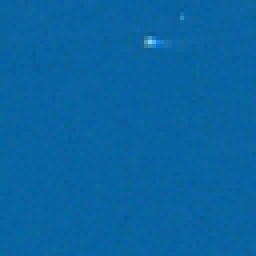

In [18]:
# Preview an train data image
print(train_labels[0])
array_to_img(train_images[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


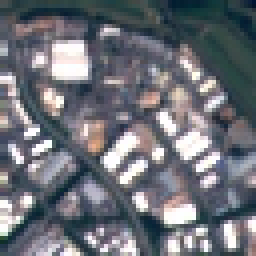

In [19]:
# Preview a test data image
print(test_labels[0])
array_to_img(test_images[0])

## Modeling

In [96]:
# m_train = train_images.shape[0]
# num_px = train_images.shape[1]
# m_test = test_images.shape[0]
# # m_val = val_images.shape[0]

# print ("Number of training samples: " + str(m_train))
# print ("Number of testing samples: " + str(m_test))
# # print ("Number of validation samples: " + str(m_val))
# print ("train_images shape: " + str(train_images.shape))
# print ("train_labels shape: " + str(train_labels.shape))
# print ("test_images shape: " + str(test_images.shape))
# print ("test_labels shape: " + str(test_labels.shape))
# # print ("val_images shape: " + str(val_images.shape))
# # print ("val_labels shape: " + str(val_labels.shape))

In [97]:
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# # val_img = val_images.reshape(val_images.shape[0], -1)

# print(train_img.shape)
# print(test_img.shape)
# # print(val_img.shape)

In [93]:
# train_y = np.reshape(train_labels[:,0], (128,1))
# test_y = np.reshape(test_labels[:,0], (128,1))
# # val_y = np.reshape(val_labels[:,0], (200,1))

### Baseline Model

In [20]:
#Instantiate a Sequential model
baseline_model = Sequential()


# Input Layer- Convolution
baseline_model.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- connect all nodes with dense layer
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
baseline_model.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
baseline_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 516128)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                33032256  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 33,033,802
Trainable params: 33,033,802
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Fit the model 
baseline_history = baseline_model.fit(train_generator, 
                                      epochs = 20, 
                                      batch_size= 128, 
                                      verbose = 1, 
                                      validation_data = val_generator)

Epoch 1/5
148/148 [==============================] - 299s 2s/step - loss: 3.1271 - accuracy: 0.2569 - val_loss: 1.6714 - val_accuracy: 0.3674
Epoch 2/5
148/148 [==============================] - 287s 2s/step - loss: 1.5236 - accuracy: 0.4086 - val_loss: 1.4423 - val_accuracy: 0.4456
Epoch 3/5
148/148 [==============================] - 289s 2s/step - loss: 1.3551 - accuracy: 0.4741 - val_loss: 1.3214 - val_accuracy: 0.4785
Epoch 4/5
148/148 [==============================] - 288s 2s/step - loss: 1.2343 - accuracy: 0.5362 - val_loss: 1.1967 - val_accuracy: 0.5615
Epoch 5/5
148/148 [==============================] - 289s 2s/step - loss: 1.1562 - accuracy: 0.5709 - val_loss: 1.1298 - val_accuracy: 0.5796


In [22]:
#Check loss and accuracy on test data
test_loss, test_acc = baseline_model.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 25s 586ms/step - loss: 1.1399 - accuracy: 0.5715
Test loss:  1.1399195194244385
Test accuracy:  0.571481466293335


It looks like after 5 Epochs our baseline model has an train and test accuracy of about 57%. 

### First Model

Let's make our CNN "deeper" and add additonal convolution and max pooling layers.

In [25]:
#Instantiate a Sequential model
model_one = Sequential()


# Input Layer- Convolution
model_one.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_one.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_one.add(layers.Conv2D(32, (4, 4), activation='relu'))

# Layer 3- another max pool layer
model_one.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_one.add(Flatten())
model_one.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_one.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_one.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_one.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

Let's also add a stopping criteria as we will be running our models for more epochs.

In [30]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_one_history = model_one.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 536s 4s/step - loss: 1.9524 - accuracy: 0.2476 - val_loss: 1.7115 - val_accuracy: 0.3044
Epoch 2/20
148/148 [==============================] - 528s 4s/step - loss: 1.6564 - accuracy: 0.3626 - val_loss: 1.5844 - val_accuracy: 0.3937
Epoch 3/20
148/148 [==============================] - 528s 4s/step - loss: 1.5618 - accuracy: 0.4071 - val_loss: 1.5368 - val_accuracy: 0.4019
Epoch 4/20
148/148 [==============================] - 524s 4s/step - loss: 1.5130 - accuracy: 0.4306 - val_loss: 1.4690 - val_accuracy: 0.4641
Epoch 5/20
148/148 [==============================] - 526s 4s/step - loss: 1.3927 - accuracy: 0.4829 - val_loss: 1.3521 - val_accuracy: 0.4941
Epoch 6/20
148/148 [==============================] - 528s 4s/step - loss: 1.1429 - accuracy: 0.5815 - val_loss: 1.4810 - val_accuracy: 0.4415
Epoch 7/20
148/148 [==============================] - 527s 4s/step - loss: 1.0788 - accuracy: 0.6037 - val_loss: 1.1528 - val_accuracy: 0.5700

In [31]:
#Check loss and accuracy on test data
test_loss, test_acc = model_one.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 41s 956ms/step - loss: 1.1719 - accuracy: 0.6444
Test loss:  1.1719359159469604
Test accuracy:  0.644444465637207


In [ ]:
# # probability for each class
# y_proba = model_images.predict(x_test)
# y_proba

In [ ]:
# # argmax axis = -1 gets the column index of maximum probability for each row.
# # column index corresponds to digit classes (numbers 0 -9)
# predicted = np.argmax(y_proba, axis=-1)
# predicted

In [ ]:
# #View confusion matrix of test predictions
# cm_digits = confusion_matrix(y_test, predicted)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm_digits)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

### Adding Regularization

#### Model 2- L1 Regularization

In [42]:
#Instantiate a Sequential model
model_l1 = Sequential()


# Input Layer- Convolution
model_l1.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3),
                     kernel_regularizer=regularizers.l1(0.005)))


# Layer 1- max pool in 2x2 window
model_l1.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_l1.add(layers.Conv2D(32, (4, 4), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))

# Layer 3- another max pool layer
model_l1.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_l1.add(Flatten())
model_l1.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l1(0.005)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_l1.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_l1.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_l1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                7872576   
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [43]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_l1_history = model_l1.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 542s 4s/step - loss: 13.3760 - accuracy: 0.2088 - val_loss: 7.1874 - val_accuracy: 0.2570
Epoch 2/20
148/148 [==============================] - 532s 4s/step - loss: 7.0548 - accuracy: 0.2457 - val_loss: 6.8582 - val_accuracy: 0.2189
Epoch 3/20
148/148 [==============================] - 530s 4s/step - loss: 6.8965 - accuracy: 0.2613 - val_loss: 6.8073 - val_accuracy: 0.2685
Epoch 4/20
148/148 [==============================] - 531s 4s/step - loss: 6.8014 - accuracy: 0.2686 - val_loss: 6.6862 - val_accuracy: 0.3000
Epoch 5/20
148/148 [==============================] - 528s 4s/step - loss: 6.7419 - accuracy: 0.2755 - val_loss: 6.8024 - val_accuracy: 0.2541
Epoch 6/20
148/148 [==============================] - 527s 4s/step - loss: 6.7181 - accuracy: 0.2845 - val_loss: 6.6655 - val_accuracy: 0.2967
Epoch 7/20
148/148 [==============================] - 528s 4s/step - loss: 6.6928 - accuracy: 0.2844 - val_loss: 6.6423 - val_accuracy: 0.279

In [44]:
#Check loss and accuracy on test data
test_loss, test_acc = model_l1.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 38s 883ms/step - loss: 6.5853 - accuracy: 0.3015
Test loss:  6.585337162017822
Test accuracy:  0.3014814853668213


#### Model 3- L2 Regularization

In [45]:
#Instantiate a Sequential model
model_l2 = Sequential()


# Input Layer- Convolution
model_l2.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3),
                     kernel_regularizer=regularizers.l2(0.005)))


# Layer 1- max pool in 2x2 window
model_l2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_l2.add(layers.Conv2D(32, (4, 4), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l2(0.005)))

# Layer 3- another max pool layer
model_l2.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_l2.add(Flatten())
model_l2.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(0.005)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_l2.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_l2.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_l2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                7872576   
_________________________________________________________________
dense_15 (Dense)             (None, 10)              

In [46]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_l2_history = model_l2.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 529s 4s/step - loss: 2.2535 - accuracy: 0.3123 - val_loss: 1.7472 - val_accuracy: 0.4378
Epoch 2/20
148/148 [==============================] - 529s 4s/step - loss: 1.7020 - accuracy: 0.4045 - val_loss: 1.6228 - val_accuracy: 0.4256
Epoch 3/20
148/148 [==============================] - 529s 4s/step - loss: 1.5932 - accuracy: 0.4484 - val_loss: 1.5801 - val_accuracy: 0.4285
Epoch 4/20
148/148 [==============================] - 529s 4s/step - loss: 1.5286 - accuracy: 0.4637 - val_loss: 1.4975 - val_accuracy: 0.5259
Epoch 5/20
148/148 [==============================] - 531s 4s/step - loss: 1.4671 - accuracy: 0.4776 - val_loss: 1.4665 - val_accuracy: 0.4781
Epoch 6/20
148/148 [==============================] - 529s 4s/step - loss: 1.4333 - accuracy: 0.4935 - val_loss: 1.4403 - val_accuracy: 0.4711
Epoch 7/20
148/148 [==============================] - 530s 4s/step - loss: 1.4069 - accuracy: 0.5130 - val_loss: 1.4653 - val_accuracy: 0.5004

In [47]:
#Check loss and accuracy on test data
test_loss, test_acc = model_l2.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 38s 888ms/step - loss: 1.0962 - accuracy: 0.6648
Test loss:  1.0961918830871582
Test accuracy:  0.664814829826355


#### Model 4- Dropout Regularization

In [48]:
#Instantiate a Sequential model
model_dropout = Sequential()


# Input Layer- Dropout
model_dropout.add(layers.Dropout(0.3, input_shape= (256, 256, 3)))

#Convolution Layer
model_dropout.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

# Layer 1- max pool in 2x2 window
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(layers.Dropout(0.3, input_shape=(2000,)))

# Layer 2- another convolution layer 
model_dropout.add(layers.Conv2D(32, (4, 4), activation='relu'))

# Layer 3- another max pool layer
model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Dropout(0.3, input_shape=(2000,)))

# Layer 4- connect all nodes with dense layer
model_dropout.add(Flatten())
model_dropout.add(Dense(64, activation='relu'))

model_dropout.add(layers.Dropout(0.3, input_shape=(2000,)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_dropout.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_dropout.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_dropout.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 62, 62, 32)      

In [49]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_dropout_history = model_dropout.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 609s 4s/step - loss: 2.6446 - accuracy: 0.1148 - val_loss: 2.2975 - val_accuracy: 0.1111
Epoch 2/20
148/148 [==============================] - 608s 4s/step - loss: 2.2962 - accuracy: 0.1124 - val_loss: 2.2952 - val_accuracy: 0.1111
Epoch 3/20
148/148 [==============================] - 611s 4s/step - loss: 2.2955 - accuracy: 0.1103 - val_loss: 2.2949 - val_accuracy: 0.1111
Epoch 4/20
148/148 [==============================] - 608s 4s/step - loss: 2.2952 - accuracy: 0.1119 - val_loss: 2.2948 - val_accuracy: 0.1111
Epoch 5/20
148/148 [==============================] - 607s 4s/step - loss: 2.2950 - accuracy: 0.1100 - val_loss: 2.2948 - val_accuracy: 0.1111
Epoch 6/20
148/148 [==============================] - 608s 4s/step - loss: 2.2952 - accuracy: 0.1113 - val_loss: 2.2948 - val_accuracy: 0.1111
Epoch 7/20
148/148 [==============================] - 610s 4s/step - loss: 2.2952 - accuracy: 0.1118 - val_loss: 2.2948 - val_accuracy: 0.1111

In [50]:
#Check loss and accuracy on test data
test_loss, test_acc = model_dropout.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 37s 860ms/step - loss: 2.2948 - accuracy: 0.1111
Test loss:  2.294809341430664
Test accuracy:  0.1111111119389534


## Evaluation

## Conclusion

### Recommendations

### Next Steps